### Spencer Investment Strategy Analysis
Objective: run a simulation to measure the returns of investing in the top 100 market cap stocks, but only purchasing after they have dropped to x% below their 52 week high. And then selling those stocks once they surpass y% of my purchase price. Run simulation for z years, re-evaluating stocks every certain number of days.

Constraints: 
- buy a specific amount of stock every time a buy signal is triggered.
- allow the purchase of fractional shares.
- total outstanding investment amount is limited by an initial investment amount. Therefore, outstanding investment amount (the amount of money spent on purchasing the current stock portfolio) cannot exceed initial investment amount, plus any profits derived from selling stocks for gain.

Any total cash available for investment not invested in this strategy's stock portfolio is invested in the S&P 500.


Alternatively, invest the entire initial cash available for investment in the S&P 500, and hold until present.


### User Inputs

In [1]:
# How much money to invest when a buy signal is triggered (in USD)
investment_amount_per_buy_signal = 100

# How much initial money is available to invest
initial_cash_available_for_investment = 10000

# Number of years to look back
lookback_years = 5

# How many days between each buy/sell check
# 1 means buy/sell every day for lookback_years
buy_sell_interval_in_days = 1

# Can the same stock be bought again if it is already in the portfolio?
allow_buy_stock_already_in_portfolio = False

# Logging parameters
output_portfolio = False
output_transactions = True
output_non_spy_investment = False

### Simulation parameters
These should be varied to find the values that produce the highest return.

In [2]:
# Buy and sell percentages
buy_after_52_week_high_percentage_drop = 0.2
sell_after_percentage_rise_from_purchase_price = 0.1

### Installs

In [3]:
!pip install -q yfinance
!pip install -q scipy

### Imports

In [4]:
import yfinance as yf
import scipy.optimize as optimize
import pandas as pd
from datetime import datetime, timedelta

In [5]:
# Calculate the start date. End date of the simulation is 2 days ago. 
start_date = (datetime.now() - timedelta(days=365 * lookback_years + 2)).strftime('%Y-%m-%d')
end_date = (datetime.now() - timedelta(days=2)).strftime('%Y-%m-%d')

In [6]:
# Hard-coded list of stocks in the S&P 100 as of September 18, 2023
# TODO: Automatically fetch this list for each day of the simulation
# sp100_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN'] # Smaller list, for testing purposes
sp100_stocks = ['AAPL', 'ABBV ', 'ABT ', 'ACN ', 'ADBE ', 'AIG ', 'AMD ', 'AMGN ', 'AMT ', 'AMZN ', 'AVGO ', 'AXP ', 'BA ', 'BAC ', 'BK ', 'BKNG ', 'BLK ', 'BMY ', 'BRK-B ', 'C ', 'CAT ', 'CHTR ', 'CL ', 'CMCSA ', 'COF ', 'COP ', 'COST ', 'CRM ', 'CSCO ', 'CVS ', 'CVX ', 'DE ', 'DHR ', 'DIS ', 'DOW ', 'DUK ', 'EMR ', 'EXC ', 'F ', 'FDX ', 'GD ', 'GE ', 'GILD ', 'GM ', 'GOOG ', 'GOOGL ', 'GS ', 'HD ', 'HON ', 'IBM ', 'INTC ', 'JNJ ', 'JPM ', 'KHC ', 'KO ', 'LIN ', 'LLY ', 'LMT ', 'LOW ', 'MA ', 'MCD ', 'MDLZ ', 'MDT ', 'MET ', 'META ', 'MMM ', 'MO ', 'MRK ', 'MS ', 'MSFT ', 'NEE ', 'NFLX ', 'NKE ', 'NVDA ', 'ORCL ', 'PEP ', 'PFE ', 'PG ', 'PM ', 'PYPL ', 'QCOM ', 'RTX ', 'SBUX ', 'SCHW ', 'SO ', 'SPG ', 'T ', 'TGT ', 'TMO ', 'TMUS ', 'TSLA ', 'TXN ', 'UNH ', 'UNP ', 'UPS ', 'USB ', 'V ', 'VZ ', 'WFC ', 'WMT ', 'XOM ']

Initialize data structures to keep track of:
- Transactions, keeping a log of all executed buy and sell operations
- Current Portfolio, consisting of several stock tickers purchased at some previous date and not yet sold
- Investment in non-SPY stocks by date, keeping track of how much money has been invested to buy stocks according to this investment strategy (that is, not the S&P500 index)

In [7]:
# DataFrames for transactions, current portfolio, and 
transactions = pd.DataFrame(columns=[
    'Date', 
    'Ticker',
    'Action',
    'Buy_or_Sell_Price',
    'Number_of_Shares',
    'Cash_Flow',
    'Entry_ID'
])

portfolio = pd.DataFrame(columns=[
    'Entry_ID',
    'Ticker',
    'Shares',
    'Purchase_Price',
    'Date_Purchased',
])

non_spy_investment_amount = pd.DataFrame(columns=[
    'Date',
    'Non_SPY_Investment_Amount'
])

portfolio_value = pd.DataFrame(columns=[
    'Date',
    'Portfolio_Value',
    'SPY_Portfolio_Value'
])

Also initialize an alternate portfolio consisting of only investing in the S&P 500

In [8]:
alt_transactions = pd.DataFrame(columns=[
    'Date', 
    'Ticker',
    'Action',
    'Buy_or_Sell_Price',
    'Number_of_Shares',
    'Cash_Flow',
    'Entry_ID'
])

alt_portfolio = pd.DataFrame(columns=[
    'Entry_ID',
    'Ticker',
    'Shares',
    'Purchase_Price'
])

alt_portfolio_value = pd.DataFrame(columns=[
    'Date',
    'Portfolio_Value',
    'SPY_Portfolio_Value'
])

### Function Definitions

In [9]:
def get_stock_value_in_portfolio(portfolio, ticker, date, spy_historical_data, current_price=None):
    """
    Calculates the aggregate value of a given stock ticker in a portfolio on a specified date. Uses SPY historical data
    for SPY ticker to find the current price.

    Args:
        portfolio (pandas.DataFrame): A DataFrame representing the investment portfolio.
            Must have a 'Ticker' and 'Shares' column.
        ticker (str): The stock ticker symbol.
        date (str or datetime.date): The date for which to calculate the value.
        spy_historical_data (pd.DataFrame): Historical data for SPY, used if the ticker is 'SPY'.
        current_price (float, optional): The current price of the stock. If not provided, the price is fetched
            using historical data for non-SPY tickers or spy_historical_data for SPY.

    Returns:
        float: The total value of the specified stock in the portfolio on the given date.
            Returns 0.0 if the stock is not found in the portfolio.
    """
    if ticker not in portfolio['Ticker'].values:
        return 0.0  # Stock not in portfolio

    # Get number of shares from the portfolio
    shares_owned = 0.0
    if ticker in portfolio['Ticker'].values:
        matching_rows = portfolio[portfolio['Ticker'] == ticker]
        shares_owned = matching_rows['Shares'].sum()

    if current_price is None:
        if ticker == 'SPY':
            # Use spy_historical_data for SPY
            spy_filtered_data = spy_historical_data[spy_historical_data.index <= date]
            current_price = spy_filtered_data['Close'].iloc[-1]
        else:
            # Use yfinance to fetch current price for non-SPY tickers
            current_price = yf.download(ticker, start=date, end=date, progress=False).get('Close', [0])[0]

    return shares_owned * current_price

In [10]:
def get_value_of_full_portfolio(portfolio, date, historical_data, spy_historical_data):
    """
    Calculates the total value of a portfolio on a given date.

    Args:
        portfolio (pd.DataFrame): A DataFrame containing portfolio holdings.
        date (str): The date for which to calculate the portfolio's value.
        historical_data (dict): A dictionary of DataFrames containing historical data for each ticker in the portfolio.
        spy_historical_data (pd.DataFrame): A DataFrame containing historical data for SPY.

    Returns:
        float: The total value of the portfolio on the specified date.
    """
    total_value = 0.0

    for _, row in portfolio.iterrows():
        ticker = row['Ticker']
        shares = row['Shares']

        # Get the historical data for the current ticker
        if ticker in historical_data:
            # Get the data for this ticker
            data = historical_data[ticker]
        elif ticker == 'SPY':
            data = spy_historical_data

        # Find the last available price before or on the end_date
        # Filter the data up to and including the end_date
        filtered_data = data[data.index <= date]

        # Check if the date is in the data and if so, get the closing price
        if not filtered_data.empty:
            # Get the last available closing price
            last_price = filtered_data['Close'].iloc[-1]
            total_value += shares * last_price

    return total_value

In [11]:
def update_portfolio_value(portfolio_value, portfolio, date, historical_data, spy_historical_data):
    """
    Updates a DataFrame with the total portfolio value and the value of SPY holdings for a given date.

    Args:
        portfolio (pd.DataFrame): The portfolio holdings.
        date (str): The date for the valuation.
        historical_data (dict): Historical data for each ticker in the portfolio.
        spy_historical_data (pd.DataFrame): Historical data for SPY.

    Returns:
        pd.DataFrame: Updated DataFrame with columns ['Date', 'Portfolio_Value', 'SPY_Portfolio_Value'].
    """
    # Calculate total portfolio value
    total_portfolio_value = get_value_of_full_portfolio(portfolio, date, historical_data, spy_historical_data)
    
    # Calculate SPY portfolio value
    spy_portfolio_value = get_stock_value_in_portfolio(portfolio, 'SPY', date, spy_historical_data)
    
    # Prepare the data to be appended/updated
    new_data = {
        'Date': [date],
        'Portfolio_Value': [total_portfolio_value],
        'SPY_Portfolio_Value': [spy_portfolio_value]
    }
    
    portfolio_value_row = pd.DataFrame(new_data)
    
    # Check if the date already exists in the DataFrame
    if 'Date' in portfolio_value.columns and date in portfolio_value['Date'].values:
        # If the date exists, update the row
        idx = portfolio_value.index[portfolio_value['Date'] == date][0]
        portfolio_value.loc[idx, 'Portfolio_Value'] = total_portfolio_value
        portfolio_value.loc[idx, 'SPY_Portfolio_Value'] = spy_portfolio_value
    else:
        # If the date does not exist, append the new row
        portfolio_value = pd.concat([portfolio_value, portfolio_value_row], ignore_index=True)
    
    return portfolio_value

In [12]:
def update_non_spy_investment_amount(non_spy_investment_amount, date, amount):
    '''
    Updates the total non-SPY (S&P 500 Index Fund) investment amount for a given date, adjusting for new transactions.

    This function modifies the DataFrame containing non-SPY investment amounts by either adding a new 
    entry for the specified date or updating an existing entry. The `amount` can be positive 
    (indicating a purchase) or negative (indicating a sale).

    Args:
        non_spy_investment_amount (pandas.DataFrame): A DataFrame with columns ['Date', 'Non_SPY_Investment_Amount'] representing the historical non-SPY investment amounts over time.
        date (datetime.date or compatible string): The date of the transaction. This function assumes that the `date` column in `non_spy_investment_amount` DataFrame is of a compatible type.
        amount (float): The amount by which the non-SPY investment changes on the given date. This can be a positive number (for additions to the investment) or a negative number (for reductions in the investment).

    Returns:
        pandas.DataFrame: An updated DataFrame with the adjusted non-SPY investment amount for the specified date. 
    '''

    if non_spy_investment_amount.empty or date not in non_spy_investment_amount['Date'].values:
        if not non_spy_investment_amount.empty:
            # If there's a previous entry, carry over the last outstanding amount and add the current amount
            last_amount = non_spy_investment_amount.iloc[-1]['Non_SPY_Investment_Amount']
            new_amount = last_amount + amount
        else:
            # If there are no previous entries, this is the first transaction
            new_amount = amount
        non_spy_investment_amount.loc[len(non_spy_investment_amount)] = [date, new_amount]
    else:
        # Update the existing entry for the date
        last_index = non_spy_investment_amount[non_spy_investment_amount['Date'] == date].index[-1]
        non_spy_investment_amount.at[last_index, 'Non_SPY_Investment_Amount'] += amount
        
    return non_spy_investment_amount

In [13]:
# Function to simulate buying
def buy_stock(transactions, 
              portfolio,
              amount_to_buy, 
              date, 
              ticker,
              close_price,
              entry_id=False,
              non_spy_investment_amount=None
             ):
    '''
    Simulates a stock purchase within an investment strategy. Updates transaction records, 
    the investment portfolio, and outstanding investment calculations.

    Args:
        transactions (pandas.DataFrame): A DataFrame to store historical transactions.
        portfolio (pandas.DataFrame): A DataFrame representing the current investment holdings.
        date (datetime.date): The date of the stock purchase.
        ticker (str): The ticker symbol of the purchased stock.
        close_price (float): The closing price of the stock at the time of purchase.
        entry_id (str, optional): A unique Entry_ID to identify the purchase. If not 
                                   provided, a new Entry_ID will be automatically generated.
        non_spy_investment_amount (pandas.DataFrame, optional): A DataFrame representing a historical log 
            of amount of money invested in non-SPY holdings.

    Returns:
        tuple: A tuple containing: 
               * updated transactions DataFrame
               * updated portfolio DataFrame
               * the Entry_ID used for the transaction (either provided or generated)
    '''

    shares_bought = amount_to_buy / close_price

    # if an entry_id is not already provided, generate a unique Entry_ID using a high-resolution timestamp
    if not entry_id:
        entry_id = datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')

    # Update transactions DataFrame
    new_transaction_entry = pd.DataFrame({
        'Date': [date],
        'Ticker': [ticker],
        'Action': ['Buy'],
        'Buy_or_Sell_Price': [close_price],
        'Number_of_Shares': [shares_bought],
        'Cash_Flow': [-amount_to_buy], # This is a negative cash flow
        'Entry_ID': [entry_id]
    })

    transactions = pd.concat([transactions, new_transaction_entry], ignore_index=True)

    # Update portfolio DataFrame
    new_portfolio_entry = pd.DataFrame({
        'Entry_ID': [entry_id],
        'Ticker': [ticker], 
        'Shares': [shares_bought], 
        'Purchase_Price': [close_price],
        'Date_Purchased': [date],
    })

    portfolio = pd.concat([portfolio, new_portfolio_entry], ignore_index=True)

    if ticker != 'SPY' and non_spy_investment_amount is not None:
        # This is a regular purchase
        non_spy_investment_amount = update_non_spy_investment_amount(
            non_spy_investment_amount, date, investment_amount_per_buy_signal)

    # Logging the buy
    if output_transactions:
        print(
            f"Buy: {date.strftime('%Y-%m-%d')} - {ticker}, "
            f"Shares: {shares_bought:.4f}, Price: {close_price}, "
            f"Value: {amount_to_buy:.2f}"
        )

    return transactions, portfolio, non_spy_investment_amount, entry_id

In [14]:
# Function to simulate selling
def sell_stock(transactions, 
               portfolio,
               date, 
               sell_mode,
               target_amount=None, 
               ticker=None, 
               entry_id=None, 
               order='FIFO', 
               current_price=None, 
               non_spy_investment_amount=None
              ):
    '''
    Simulates a stock sale, supporting various selling modes including selling by entry ID, selling a specified amount of a stock by ticker, or selling all shares of a specified ticker.

    Args:
        transactions (pandas.DataFrame): A DataFrame to store historical transactions.
        portfolio (pandas.DataFrame): A DataFrame representing current investment holdings.
        date (datetime.date): The date of the stock sale.
        sell_mode (str): Determines the selling behavior - 'entry_id' for selling by specific Entry ID, 'amount' for selling to reach a target amount in USD, and 'all' for selling all shares of a specified ticker.
        target_amount (float, optional): The target USD amount to be raised through the sale when sell_mode is 'amount'.
        ticker (str, optional): The ticker symbol of the stock to sell, required for 'amount' and 'all' sell modes.
        entry_id (str, optional): The specific Entry ID to sell when sell_mode is 'entry_id'.
        order (str, optional): Specifies the order to sell shares, 'FIFO' (First-In, First-Out) or 'LIFO' (Last-In, First-Out), applicable to 'amount' sell mode. Defaults to 'FIFO'.
        current_price (float, optional): The current stock price for the sale. If not provided, the price is fetched using yfinance.
        non_spy_investment_amount (pandas.DataFrame, optional): A DataFrame representing a historical log 
            of amount of money invested in non-SPY holdings.

    Returns:
        tuple: A tuple containing the updated transactions and portfolio DataFrames, and the updated outstanding investment.
    '''
    
    if sell_mode not in ['entry_id', 'amount', 'all']:
        raise ValueError("sell_mode must be 'entry_id', 'amount', or 'all'.")

    if sell_mode == 'entry_id' and entry_id is None:
        raise ValueError("entry_id is required when sell_mode is 'entry_id'.")

    if sell_mode == 'amount' and (ticker is None or target_amount is None):
        raise ValueError("Both ticker and target_amount are required when sell_mode is 'amount'.")

    if sell_mode == 'all' and ticker is None:
        raise ValueError("ticker is required when sell_mode is 'all'.")

        
    if sell_mode == 'entry_id':
        
        # Locate the transaction to be sold using Entry_ID
        transaction_index = portfolio[portfolio['Entry_ID'] == entry_id].index
        if not transaction_index.empty:
            index = transaction_index[0]
            ticker = portfolio.at[index, 'Ticker']
            if not current_price:
                sell_price = yf.download(ticker, date, date)['Close'][0]
            else:
                sell_price = current_price
            shares_to_sell = portfolio.at[index, 'Shares']
            sold_value = shares_to_sell * sell_price

            # Update transactions DataFrame with the sale information
            new_sale_entry = pd.DataFrame({
                'Date': [date],
                'Ticker': [ticker],
                'Action': ['Sell'],
                'Buy_or_Sell_Price': [sell_price],
                'Number_of_Shares': [shares_to_sell],
                'Cash_Flow': [sold_value],
                'Entry_ID': [entry_id]
            })

            transactions = pd.concat([transactions, new_sale_entry], ignore_index=True)

            if ticker != 'SPY' and non_spy_investment_amount is not None:
                # This is a regular sell
                non_spy_investment_amount = update_non_spy_investment_amount(
                    non_spy_investment_amount, date, -investment_amount_per_buy_signal)

            # Remove the sold stock from the portfolio
            portfolio.drop(index, inplace=True)
            portfolio.reset_index(drop=True, inplace=True)

            # Logging the sale
            if output_transactions:
                print(
                    f"Sell: {date.strftime('%Y-%m-%d')} - {ticker}, "
                    f"Shares: {shares_to_sell:.4f}, Price: {sell_price}, "
                    f"Value: {sold_value:.2f}"
                )
        
        else:
            raise KeyError(f"ERROR: Entry ID {entry_id} not found in the portfolio.")
            
    elif sell_mode == 'amount':
        if not current_price:
            sell_price = yf.download(ticker, date, date)['Close'][0]
        else:
            sell_price = current_price
            
        # Assumption: there are enough shares available to sell to meet target amount

        shares_to_sell =  0  # Initialize

        if order == 'FIFO':
            rows_to_update = portfolio[portfolio['Ticker'] == ticker].copy() 
            rows_to_update.sort_values(by='Date_Purchased', inplace=True)  # Sort by 'Date_Purchased' - FIFO
        else:  # order == 'LIFO'
            rows_to_update = portfolio[portfolio['Ticker'] == ticker].iloc[::-1].copy() 
            rows_to_update.sort_values(by='Date_Purchased', inplace=True, ascending=False)  # Sort in descending order - LIFO

        remaining_amount_to_cover = target_amount
        for i, row in rows_to_update.iterrows():
            if remaining_amount_to_cover <= 0:
                break

            num_shares = row['Shares']
            sale_value = num_shares * sell_price
            
            if sale_value < remaining_amount_to_cover:
                # Full sale of this row's shares
                remaining_amount_to_cover -= sale_value  # Decrease target amount by the value of shares being sold
                shares_to_sell += num_shares  # Add these shares to the total count of shares to sell
                portfolio.drop(i, inplace=True)  # Remove this row from the portfolio as all shares are sold
            else:
                # Partial sale of shares to meet the exact target amount
                partial_shares_to_sell = remaining_amount_to_cover / sell_price  # Determine the number of shares needed to meet the remaining target amount
                shares_to_sell += partial_shares_to_sell  # Update the total shares to sell
                remaining_shares = num_shares - partial_shares_to_sell  # Calculate remaining shares after sale
                portfolio.at[i, 'Shares'] = remaining_shares  # Update the portfolio to reflect the remaining shares
                remaining_amount_to_cover = 0  # Target has been made
                break  # Exit loop as the target amount has been reached

        # Update transactions DataFrame 
        new_sale_entry = pd.DataFrame({
            'Date': [date],
            'Ticker': [ticker],
            'Action': ['Sell'],
            'Buy_or_Sell_Price': [sell_price],
            'Number_of_Shares': [shares_to_sell],
            'Cash_Flow': [target_amount],  # Record the actual amount raised
            'Entry_ID': ['N/A (Multiple)']  # Indicate that multiple entries might be affected
        })
        
        transactions = pd.concat([transactions, new_sale_entry], ignore_index=True)
        
        # No need to update non-SPY investments, because this sell mode is only used when selling SPY

        # Logging the sale
        if output_transactions:
            print(
                f"Sell: {date.strftime('%Y-%m-%d')} - {ticker}, "
                f"Shares: {shares_to_sell:.4f}, Price: {sell_price}, "
                f"Value: {target_amount:.2f}"
            )

    elif sell_mode == 'all':

        if not current_price:
            sell_price = yf.download(ticker, date, date)['Close'][0]
        else:
            sell_price = current_price

        # Collect relevant rows, no need for FIFO/LIFO ordering
        rows_to_update = portfolio[portfolio['Ticker'] == ticker].copy()

        shares_to_sell = rows_to_update['Shares'].sum()
        sold_value = shares_to_sell * sell_price

        # Update transactions DataFrame
        new_sale_entry = pd.DataFrame({
            'Date': [date],
            'Ticker': [ticker],
            'Action': ['Sell'],
            'Buy_or_Sell_Price': [sell_price], 
            'Number_of_Shares': [shares_to_sell],
            'Cash_Flow': [sold_value],  
            'Entry_ID': ['N/A (Multiple)'] 
        })
        
        transactions = pd.concat([transactions, new_sale_entry], ignore_index=True)

        # No need to update non-SPY investments, because this sell mode is only used when selling SPY

        # Remove the sold stock from the portfolio
        portfolio.drop(rows_to_update.index, inplace=True)  
        portfolio.reset_index(drop=True, inplace=True) 

        if output_transactions:
            print(
                f"Sell: {date.strftime('%Y-%m-%d')} - {ticker}, "
                f"Shares: {shares_to_sell:.4f}, Price: {sell_price}, "
                f"Value: {sold_value:.2f}"
            )

    else:
        raise ValueError("Invalid sell_mode. Must be 'entry_id', 'amount', or 'all'")

    return transactions, portfolio, non_spy_investment_amount

In [15]:
# Source: https://stackoverflow.com/questions/8919718/financial-python-library-that-has-xirr-and-xnpv-function
def xnpv(rate, values, dates):
   '''
   Equivalent of Excel's XNPV function.
   '''
   return sum([v / (1 + rate)**((d - dates[0]).days / 365.0) for d, v in zip(dates, values)])

def xirr(transactions):
    """
    Calculates the XIRR (Internal Rate of Return with irregular dates) from a DataFrame of transactions.

    Args:
        transactions (pandas.DataFrame): A DataFrame with the columns:
            * Date (datetime): The date of the transaction.
            * Cash_Flow (float): The amount of cash invested or returned.

    Returns:
        float: The XIRR (Internal Rate of Return) as a percentage.
    """

    dates = transactions['Date'].dt.to_pydatetime()
    cash_flows = transactions['Cash_Flow'].to_numpy()

    try:
        return optimize.newton(lambda r: xnpv(r, cash_flows, dates), 0.0) * 100
    except RuntimeError:  # Handle cases where XIRR can't be calculated
        return optimize.brentq(lambda r: xnpv(r, cash_flows, dates), -1.0, 1e10) * 100

In [16]:
# Load historical data for each ticker
historical_data = {ticker: yf.download(ticker, start=start_date, end=end_date, progress=False) for ticker in sp100_stocks}
for ticker, data in historical_data.items():
    # The choice of 252 days is based on the typical number of trading days in a year for the U.S. stock market, which is commonly used as an approximation for a 52-week period.
    # The calculated 52-week high at any given row in the DataFrame represents the highest closing price over the preceding 252 trading days from that row
    data['52_Week_High'] = data['Close'].rolling(window=252).max()

# Also load historical data for SPY
spy_historical_data = yf.download('SPY', start=start_date, end=end_date, progress=False)

# Calculate the 52-Week_High for SPY
spy_historical_data['52_Week_High'] = spy_historical_data['Close'].rolling(window=252).max() 

### Main Simulation Loop

In [17]:
current_date = datetime.strptime(start_date, '%Y-%m-%d')
end_simulation_date = datetime.strptime(end_date, '%Y-%m-%d')

while current_date <= end_simulation_date:
    day_has_transactions = False
    
    # If this is the first day in the simulation, buy all SPY in this strategy's portfolio
    # and in the alternative S&P500 comparison portfolio
    if current_date == datetime.strptime(start_date, '%Y-%m-%d'):
        spy_close_price = spy_historical_data.loc[current_date.strftime('%Y-%m-%d'), 'Close']
        transactions, portfolio, _, _ = buy_stock(
            transactions,
            portfolio,
            initial_cash_available_for_investment,
            current_date,
            'SPY', 
            spy_close_price
        )
        
        # For the alternative comparison investment, also put the initial cash available for investment 
        # in the S&P 500
        alt_transactions, alt_portfolio, _, _ = buy_stock(
            alt_transactions,
            alt_portfolio,
            initial_cash_available_for_investment,
            current_date,
            'SPY', 
            spy_close_price
        )
        
    # For each day in the simulation, check if we should buy or sell each stock
    for ticker, data in historical_data.items():
        if current_date.strftime('%Y-%m-%d') in data.index:
            row = data.loc[current_date.strftime('%Y-%m-%d')]

            # Buy logic
            # Skip buying if the stock is already in the portfolio 
            # and re-buying is not allowed (as configured by the user)
            if not (ticker in portfolio['Ticker'].values and not allow_buy_stock_already_in_portfolio):
                
                # Buy logic is triggered if stock is below a certain percentage of its 52 week high
                if row['Close'] <= row['52_Week_High'] * (1 - buy_after_52_week_high_percentage_drop):
                    
                    spy_close_price = spy_historical_data.loc[current_date.strftime('%Y-%m-%d'), 'Close']
                    
                    # How much SPY is available in the investment portfolio?
                    possible_cash_available_for_investments = get_stock_value_in_portfolio(
                        portfolio,
                        'SPY',
                        current_date.strftime('%Y-%m-%d'),
                        spy_historical_data,
                        current_price=spy_close_price
                    )
                    
                    # If there is enough cash available to buy this additional stock, 
                    # sell enough SPY and buy the stock
                    if possible_cash_available_for_investments >= investment_amount_per_buy_signal:
                        
                        # Sell SPY to cover buying the new stock
                        transactions, portfolio, _ = sell_stock(
                            transactions,
                            portfolio,
                            current_date,
                            'amount',
                            target_amount=investment_amount_per_buy_signal,
                            ticker='SPY',
                            order='FIFO',
                            current_price=spy_close_price
                        )
                    
                        # Buy stock according to the investment strategy
                        transactions, portfolio, non_spy_investment_amount, this_entry_id = buy_stock(
                            transactions,
                            portfolio,
                            investment_amount_per_buy_signal,
                            current_date,
                            ticker, 
                            row['Close'],
                            non_spy_investment_amount=non_spy_investment_amount
                        )

                        day_has_transactions = True
                    
                    else:
                        if output_transactions:
                            print(
                                "Insufficient money available to execute buy strategy. "
                                f"Date: {current_date.strftime('%Y-%m-%d')}; "
                                f" Current value of SPY in portfolio: {possible_cash_available_for_investments}; "
                                f"Ticker not bought: {ticker}"
                            )

            # Sell logic
            to_sell = []
            for index, stock in portfolio[portfolio['Ticker'] == ticker].iterrows():
                if row['Close'] >= stock['Purchase_Price'] * (1 + sell_after_percentage_rise_from_purchase_price):
                    # Add an entry to the DataFrame to_sell containing the stock to be sold. Uniquely
                    # identify the stock from the portfolio using Entry_ID
                    to_sell.append((stock['Entry_ID'], row['Close']))
            
            # Sell all stocks that meet the sell criteria
            for entry_id, sell_price in to_sell:
                
                # Sell stock according to the investment strategy
                transactions, portfolio, non_spy_investment_amount = sell_stock(
                    transactions, 
                    portfolio,
                    current_date,
                    'entry_id',
                    entry_id=entry_id,
                    order='FIFO',
                    current_price=sell_price,
                    non_spy_investment_amount=non_spy_investment_amount
                )
                
                this_sell_transaction = transactions[
                    (transactions['Entry_ID'] == entry_id) & 
                    (transactions['Action'] == 'Sell')
                ]
                
                # After selling, re-buy SPY
                transactions, portfolio, _, _ = buy_stock(
                    transactions,
                    portfolio,
                    this_sell_transaction['Cash_Flow'].iloc[0], # Whatever positive cash flow available is reinvested into SPY
                    current_date,
                    'SPY', 
                    spy_close_price
                )
                
    # Every day, update the value of the portfolio and alternative portfolio
    portfolio_value = update_portfolio_value(
        portfolio_value, portfolio, current_date, historical_data, spy_historical_data)
    alt_portfolio_value = update_portfolio_value(
        alt_portfolio_value, alt_portfolio, current_date, historical_data, spy_historical_data)

    if output_portfolio:
        # Print the current portfolio:
        portfolio_without_entry_id = portfolio.drop('Entry_ID', axis=1)
        print(f"\nCurrent Portfolio as of {current_date.strftime('%Y-%m-%d')}:")
        print(portfolio_without_entry_id)
        print("\n")
    
    # If no transactions occurred on this day, carry over the last non-SPY investment amount
    if not day_has_transactions:
        non_spy_investment_amount = update_non_spy_investment_amount(non_spy_investment_amount, current_date, 0)

    if output_non_spy_investment:
        # Print statements for current date and non-SPY investment
        if not non_spy_investment_amount.empty:
            current_non_spy_investment = non_spy_investment_amount[
                non_spy_investment_amount['Date'] == current_date.strftime(
                    '%Y-%m-%d')]['Non_SPY_Investment_Amount'].iloc[-1]
            print(
                f"Date: {current_date.strftime('%Y-%m-%d')} "
                "Outstanding Non-SPY Investment: $ "
                "{:,.2f}".format(current_non_spy_investment)
                )
        else:
            print("Date:", current_date.strftime('%Y-%m-%d'), "Current non-SPY Investment: $ 0.00")


    current_date += timedelta(days=buy_sell_interval_in_days)

Buy: 2019-04-05 - SPY, Shares: 34.6536, Price: 288.57000732421875, Value: 10000.00
Buy: 2019-04-05 - SPY, Shares: 34.6536, Price: 288.57000732421875, Value: 10000.00
Sell: 2020-04-03 - SPY, Shares: 0.4029, Price: 248.19000244140625, Value: 100.00
Buy: 2020-04-03 - AAPL, Shares: 1.6569, Price: 60.352500915527344, Value: 100.00
Sell: 2020-04-03 - SPY, Shares: 0.4029, Price: 248.19000244140625, Value: 100.00
Buy: 2020-04-03 - ABBV , Shares: 1.3630, Price: 73.37000274658203, Value: 100.00
Sell: 2020-04-03 - SPY, Shares: 0.4029, Price: 248.19000244140625, Value: 100.00
Buy: 2020-04-03 - ACN , Shares: 0.6572, Price: 152.14999389648438, Value: 100.00
Sell: 2020-04-03 - SPY, Shares: 0.4029, Price: 248.19000244140625, Value: 100.00
Buy: 2020-04-03 - ADBE , Shares: 0.3406, Price: 293.6099853515625, Value: 100.00
Sell: 2020-04-03 - SPY, Shares: 0.4029, Price: 248.19000244140625, Value: 100.00
Buy: 2020-04-03 - AIG , Shares: 4.8876, Price: 20.459999084472656, Value: 100.00
Sell: 2020-04-03 - SPY, 

Sell: 2020-04-03 - SPY, Shares: 0.4029, Price: 248.19000244140625, Value: 100.00
Buy: 2020-04-03 - V , Shares: 0.6585, Price: 151.85000610351562, Value: 100.00
Sell: 2020-04-03 - SPY, Shares: 0.4029, Price: 248.19000244140625, Value: 100.00
Buy: 2020-04-03 - WFC , Shares: 3.8124, Price: 26.229999542236328, Value: 100.00
Sell: 2020-04-03 - SPY, Shares: 0.4029, Price: 248.19000244140625, Value: 100.00
Buy: 2020-04-03 - XOM , Shares: 2.5504, Price: 39.209999084472656, Value: 100.00
Sell: 2020-04-06 - AMD , Shares: 2.3480, Price: 47.52000045776367, Value: 111.58
Buy: 2020-04-06 - SPY, Shares: 0.4496, Price: 248.19000244140625, Value: 111.58
Sell: 2020-04-06 - AXP , Shares: 1.3587, Price: 83.87000274658203, Value: 113.95
Buy: 2020-04-06 - SPY, Shares: 0.4591, Price: 248.19000244140625, Value: 113.95
Sell: 2020-04-06 - BA , Shares: 0.8031, Price: 148.77000427246094, Value: 119.47
Buy: 2020-04-06 - SPY, Shares: 0.4814, Price: 248.19000244140625, Value: 119.47
Sell: 2020-04-06 - BKNG , Shares:

Sell: 2020-04-08 - SPY, Shares: 0.3649, Price: 274.0299987792969, Value: 100.00
Buy: 2020-04-08 - LOW , Shares: 1.0599, Price: 94.3499984741211, Value: 100.00
Sell: 2020-04-08 - MDT , Shares: 1.1592, Price: 99.27999877929688, Value: 115.08
Buy: 2020-04-08 - SPY, Shares: 0.4200, Price: 274.0299987792969, Value: 115.08
Sell: 2020-04-08 - META , Shares: 0.6486, Price: 174.27999877929688, Value: 113.04
Buy: 2020-04-08 - SPY, Shares: 0.4125, Price: 274.0299987792969, Value: 113.04
Sell: 2020-04-08 - MMM , Shares: 0.8939, Price: 124.57357788085938, Value: 111.36
Buy: 2020-04-08 - SPY, Shares: 0.4064, Price: 274.0299987792969, Value: 111.36
Sell: 2020-04-08 - MS , Shares: 2.9542, Price: 39.369998931884766, Value: 116.31
Buy: 2020-04-08 - SPY, Shares: 0.4244, Price: 274.0299987792969, Value: 116.31
Sell: 2020-04-08 - SPY, Shares: 0.3649, Price: 274.0299987792969, Value: 100.00
Buy: 2020-04-08 - QCOM , Shares: 1.3637, Price: 73.33000183105469, Value: 100.00
Sell: 2020-04-08 - SBUX , Shares: 1.5

Buy: 2020-04-14 - TSLA , Shares: 2.1130, Price: 47.32600021362305, Value: 100.00
Sell: 2020-04-14 - UPS , Shares: 1.1111, Price: 101.4000015258789, Value: 112.67
Buy: 2020-04-14 - SPY, Shares: 0.3970, Price: 283.7900085449219, Value: 112.67
Sell: 2020-04-15 - SPY, Shares: 0.3600, Price: 277.760009765625, Value: 100.00
Buy: 2020-04-15 - CVS , Shares: 1.6513, Price: 60.560001373291016, Value: 100.00
Sell: 2020-04-15 - SPY, Shares: 0.3600, Price: 277.760009765625, Value: 100.00
Buy: 2020-04-15 - MO , Shares: 2.4444, Price: 40.90999984741211, Value: 100.00
Sell: 2020-04-16 - SPY, Shares: 0.3583, Price: 279.1000061035156, Value: 100.00
Buy: 2020-04-16 - MDT , Shares: 1.0449, Price: 95.69999694824219, Value: 100.00
Sell: 2020-04-17 - LMT , Shares: 0.2853, Price: 401.510009765625, Value: 114.55
Buy: 2020-04-17 - SPY, Shares: 0.4104, Price: 279.1000061035156, Value: 114.55
Sell: 2020-04-21 - SPY, Shares: 0.3662, Price: 273.0400085449219, Value: 100.00
Buy: 2020-04-21 - TXN , Shares: 0.9360, Pr

Sell: 2020-05-19 - SPY, Shares: 0.3425, Price: 291.9700012207031, Value: 100.00
Buy: 2020-05-19 - AIG , Shares: 3.6193, Price: 27.6299991607666, Value: 100.00
Sell: 2020-05-19 - SPY, Shares: 0.3425, Price: 291.9700012207031, Value: 100.00
Buy: 2020-05-19 - DIS , Shares: 0.8744, Price: 114.37000274658203, Value: 100.00
Sell: 2020-05-20 - GM , Shares: 4.3234, Price: 25.479999542236328, Value: 110.16
Buy: 2020-05-20 - SPY, Shares: 0.3773, Price: 291.9700012207031, Value: 110.16
Sell: 2020-05-21 - F , Shares: 19.8807, Price: 5.630000114440918, Value: 111.93
Buy: 2020-05-21 - SPY, Shares: 0.3834, Price: 291.9700012207031, Value: 111.93
Sell: 2020-05-21 - SPY, Shares: 0.3391, Price: 294.8800048828125, Value: 100.00
Buy: 2020-05-21 - GM , Shares: 3.8760, Price: 25.799999237060547, Value: 100.00
Sell: 2020-05-22 - BKNG , Shares: 0.0675, Price: 1631.300048828125, Value: 110.18
Buy: 2020-05-22 - SPY, Shares: 0.3736, Price: 294.8800048828125, Value: 110.18
Sell: 2020-05-22 - SPY, Shares: 0.3385, 

Sell: 2020-06-05 - SPY, Shares: 0.3131, Price: 319.3399963378906, Value: 100.00
Buy: 2020-06-05 - AIG , Shares: 2.7503, Price: 36.36000061035156, Value: 100.00
Sell: 2020-06-05 - AXP , Shares: 1.0198, Price: 109.7300033569336, Value: 111.90
Buy: 2020-06-05 - SPY, Shares: 0.3504, Price: 319.3399963378906, Value: 111.90
Sell: 2020-06-05 - BA , Shares: 0.5426, Price: 205.42999267578125, Value: 111.46
Buy: 2020-06-05 - SPY, Shares: 0.3490, Price: 319.3399963378906, Value: 111.46
Sell: 2020-06-05 - BAC , Shares: 4.0225, Price: 28.110000610351562, Value: 113.07
Buy: 2020-06-05 - SPY, Shares: 0.3541, Price: 319.3399963378906, Value: 113.07
Sell: 2020-06-05 - BRK-B , Shares: 0.5607, Price: 200.66000366210938, Value: 112.52
Buy: 2020-06-05 - SPY, Shares: 0.3523, Price: 319.3399963378906, Value: 112.52
Sell: 2020-06-05 - SPY, Shares: 0.3131, Price: 319.3399963378906, Value: 100.00
Buy: 2020-06-05 - C , Shares: 1.6989, Price: 58.86000061035156, Value: 100.00
Sell: 2020-06-05 - CMCSA , Shares: 2.6

Sell: 2020-06-23 - SPY, Shares: 0.3205, Price: 312.04998779296875, Value: 100.00
Buy: 2020-06-23 - DUK , Shares: 1.2217, Price: 81.8499984741211, Value: 100.00
Sell: 2020-07-01 - FDX , Shares: 0.7183, Price: 156.66000366210938, Value: 112.54
Buy: 2020-07-01 - SPY, Shares: 0.3606, Price: 312.04998779296875, Value: 112.54
Sell: 2020-07-08 - SPY, Shares: 0.3163, Price: 316.17999267578125, Value: 100.00
Buy: 2020-07-08 - LMT , Shares: 0.2855, Price: 350.2300109863281, Value: 100.00
Sell: 2020-07-10 - MS , Shares: 2.2437, Price: 49.79999923706055, Value: 111.73
Buy: 2020-07-10 - SPY, Shares: 0.3534, Price: 316.17999267578125, Value: 111.73
Sell: 2020-07-14 - GS , Shares: 0.5151, Price: 214.00999450683594, Value: 110.24
Buy: 2020-07-14 - SPY, Shares: 0.3487, Price: 316.17999267578125, Value: 110.24
Sell: 2020-07-15 - BKNG , Shares: 0.0630, Price: 1799.3399658203125, Value: 113.28
Buy: 2020-07-15 - SPY, Shares: 0.3583, Price: 316.17999267578125, Value: 113.28
Sell: 2020-07-22 - LMT , Shares: 

Sell: 2020-11-09 - AXP , Shares: 0.9420, Price: 117.37000274658203, Value: 110.56
Buy: 2020-11-09 - SPY, Shares: 0.3386, Price: 326.5400085449219, Value: 110.56
Sell: 2020-11-09 - BKNG , Shares: 0.0600, Price: 2118.239990234375, Value: 127.00
Buy: 2020-11-09 - SPY, Shares: 0.3889, Price: 326.5400085449219, Value: 127.00
Sell: 2020-11-09 - COF , Shares: 1.2655, Price: 86.94999694824219, Value: 110.04
Buy: 2020-11-09 - SPY, Shares: 0.3370, Price: 326.5400085449219, Value: 110.04
Sell: 2020-11-09 - CVS , Shares: 1.6589, Price: 67.52999877929688, Value: 112.03
Buy: 2020-11-09 - SPY, Shares: 0.3431, Price: 326.5400085449219, Value: 112.03
Sell: 2020-11-09 - DIS , Shares: 0.8269, Price: 142.58999633789062, Value: 117.91
Buy: 2020-11-09 - SPY, Shares: 0.3611, Price: 326.5400085449219, Value: 117.91
Sell: 2020-11-09 - GE , Shares: 2.5462, Price: 43.46165466308594, Value: 110.66
Buy: 2020-11-09 - SPY, Shares: 0.3389, Price: 326.5400085449219, Value: 110.66
Sell: 2020-11-09 - KO , Shares: 2.1308

Sell: 2021-03-08 - C , Shares: 1.5298, Price: 72.22000122070312, Value: 110.48
Buy: 2021-03-08 - SPY, Shares: 0.2894, Price: 381.7200012207031, Value: 110.48
Sell: 2021-03-08 - SPY, Shares: 0.2620, Price: 381.7200012207031, Value: 100.00
Buy: 2021-03-08 - COST , Shares: 0.3211, Price: 311.4200134277344, Value: 100.00
Sell: 2021-03-08 - SPY, Shares: 0.2620, Price: 381.7200012207031, Value: 100.00
Buy: 2021-03-08 - NVDA , Shares: 0.8626, Price: 115.93250274658203, Value: 100.00
Sell: 2021-03-11 - NVDA , Shares: 0.8626, Price: 129.93499755859375, Value: 112.08
Buy: 2021-03-11 - SPY, Shares: 0.2936, Price: 381.7200012207031, Value: 112.08
Sell: 2021-03-12 - BA , Shares: 0.4338, Price: 269.19000244140625, Value: 116.79
Buy: 2021-03-12 - SPY, Shares: 0.3059, Price: 381.7200012207031, Value: 116.79
Sell: 2021-03-15 - SPG , Shares: 0.9152, Price: 121.01000213623047, Value: 110.74
Buy: 2021-03-15 - SPY, Shares: 0.2901, Price: 381.7200012207031, Value: 110.74
Sell: 2021-03-18 - WFC , Shares: 2.7

Sell: 2021-12-07 - SPY, Shares: 0.2135, Price: 468.2799987792969, Value: 100.00
Buy: 2021-12-07 - MRK , Shares: 1.3835, Price: 72.27999877929688, Value: 100.00
Sell: 2021-12-10 - MA , Shares: 0.3175, Price: 349.9200134277344, Value: 111.11
Buy: 2021-12-10 - SPY, Shares: 0.2373, Price: 468.2799987792969, Value: 111.11
Sell: 2021-12-13 - SPY, Shares: 0.2143, Price: 466.57000732421875, Value: 100.00
Buy: 2021-12-13 - TSLA , Shares: 0.3104, Price: 322.13665771484375, Value: 100.00
Sell: 2021-12-15 - BMY , Shares: 1.8302, Price: 60.61000061035156, Value: 110.93
Buy: 2021-12-15 - SPY, Shares: 0.2377, Price: 466.57000732421875, Value: 110.93
Sell: 2021-12-17 - SPY, Shares: 0.2175, Price: 459.8699951171875, Value: 100.00
Buy: 2021-12-17 - GE , Shares: 1.7552, Price: 56.974891662597656, Value: 100.00
Sell: 2021-12-20 - SPY, Shares: 0.2198, Price: 454.9800109863281, Value: 100.00
Buy: 2021-12-20 - ADBE , Shares: 0.1819, Price: 549.77001953125, Value: 100.00
Sell: 2021-12-20 - SPY, Shares: 0.2198

Sell: 2022-03-04 - SPY, Shares: 0.2314, Price: 432.1700134277344, Value: 100.00
Buy: 2022-03-04 - GE , Shares: 1.8006, Price: 55.53572463989258, Value: 100.00
Sell: 2022-03-04 - SPY, Shares: 0.2314, Price: 432.1700134277344, Value: 100.00
Buy: 2022-03-04 - MS , Shares: 1.1579, Price: 86.36000061035156, Value: 100.00
Sell: 2022-03-04 - NEE , Shares: 1.3767, Price: 80.20999908447266, Value: 110.42
Buy: 2022-03-04 - SPY, Shares: 0.2555, Price: 432.1700134277344, Value: 110.42
Sell: 2022-03-04 - SPY, Shares: 0.2314, Price: 432.1700134277344, Value: 100.00
Buy: 2022-03-04 - V , Shares: 0.4993, Price: 200.2899932861328, Value: 100.00
Sell: 2022-03-07 - SPY, Shares: 0.2384, Price: 419.42999267578125, Value: 100.00
Buy: 2022-03-07 - BAC , Shares: 2.6082, Price: 38.34000015258789, Value: 100.00
Sell: 2022-03-07 - SPY, Shares: 0.2384, Price: 419.42999267578125, Value: 100.00
Buy: 2022-03-07 - LIN , Shares: 0.3690, Price: 270.989990234375, Value: 100.00
Sell: 2022-03-07 - SPY, Shares: 0.2384, Pri

Sell: 2022-05-12 - SPY, Shares: 0.2549, Price: 392.3399963378906, Value: 100.00
Buy: 2022-05-12 - AAPL, Shares: 0.7015, Price: 142.55999755859375, Value: 100.00
Sell: 2022-05-12 - SPY, Shares: 0.2549, Price: 392.3399963378906, Value: 100.00
Buy: 2022-05-12 - AXP , Shares: 0.6524, Price: 153.27000427246094, Value: 100.00
Sell: 2022-05-12 - SPY, Shares: 0.2549, Price: 392.3399963378906, Value: 100.00
Buy: 2022-05-12 - COST , Shares: 0.2057, Price: 486.17999267578125, Value: 100.00
Sell: 2022-05-18 - SPY, Shares: 0.2552, Price: 391.8599853515625, Value: 100.00
Buy: 2022-05-18 - TGT , Shares: 0.6188, Price: 161.61000061035156, Value: 100.00
Sell: 2022-05-18 - SPY, Shares: 0.2552, Price: 391.8599853515625, Value: 100.00
Buy: 2022-05-18 - WMT , Shares: 2.4504, Price: 40.810001373291016, Value: 100.00
Sell: 2022-05-19 - SPY, Shares: 0.2568, Price: 389.4599914550781, Value: 100.00
Buy: 2022-05-19 - UNP , Shares: 0.4619, Price: 216.5, Value: 100.00
Sell: 2022-05-20 - SPY, Shares: 0.2567, Price:

Sell: 2022-08-01 - PM , Shares: 1.1172, Price: 98.4800033569336, Value: 110.02
Buy: 2022-08-01 - SPY, Shares: 0.2785, Price: 395.0899963378906, Value: 110.02
Sell: 2022-08-03 - CVS , Shares: 1.1279, Price: 101.37999725341797, Value: 114.35
Buy: 2022-08-03 - SPY, Shares: 0.2894, Price: 395.0899963378906, Value: 114.35
Sell: 2022-08-04 - SPY, Shares: 0.2414, Price: 414.1700134277344, Value: 100.00
Buy: 2022-08-04 - ABBV , Shares: 0.7198, Price: 138.9199981689453, Value: 100.00
Sell: 2022-08-04 - MET , Shares: 1.7268, Price: 63.79999923706055, Value: 110.17
Buy: 2022-08-04 - SPY, Shares: 0.2660, Price: 414.1700134277344, Value: 110.17
Sell: 2022-08-10 - UPS , Shares: 0.5463, Price: 202.3699951171875, Value: 110.55
Buy: 2022-08-10 - SPY, Shares: 0.2669, Price: 414.1700134277344, Value: 110.55
Sell: 2022-08-11 - AIG , Shares: 2.0012, Price: 56.33000183105469, Value: 112.73
Buy: 2022-08-11 - SPY, Shares: 0.2722, Price: 414.1700134277344, Value: 112.73
Sell: 2022-08-11 - SPY, Shares: 0.2381, 

Sell: 2022-11-16 - PG , Shares: 0.7770, Price: 141.74000549316406, Value: 110.13
Buy: 2022-11-16 - SPY, Shares: 0.3089, Price: 356.55999755859375, Value: 110.13
Sell: 2022-11-18 - PM , Shares: 1.1492, Price: 96.27999877929688, Value: 110.64
Buy: 2022-11-18 - SPY, Shares: 0.3103, Price: 356.55999755859375, Value: 110.64
Sell: 2022-11-25 - MA , Shares: 0.3155, Price: 351.2900085449219, Value: 110.83
Buy: 2022-11-25 - SPY, Shares: 0.3108, Price: 356.55999755859375, Value: 110.83
Sell: 2022-11-30 - DUK , Shares: 1.1017, Price: 99.93000030517578, Value: 110.09
Buy: 2022-11-30 - SPY, Shares: 0.3088, Price: 356.55999755859375, Value: 110.09
Sell: 2022-11-30 - SCHW , Shares: 1.3344, Price: 82.54000091552734, Value: 110.14
Buy: 2022-11-30 - SPY, Shares: 0.3089, Price: 356.55999755859375, Value: 110.14
Sell: 2022-12-06 - SPY, Shares: 0.2539, Price: 393.8299865722656, Value: 100.00
Buy: 2022-12-06 - COST , Shares: 0.2078, Price: 481.1600036621094, Value: 100.00
Sell: 2022-12-12 - SO , Shares: 1.5

Sell: 2023-08-15 - SPY, Shares: 0.2258, Price: 442.8900146484375, Value: 100.00
Buy: 2023-08-15 - KHC , Shares: 2.9621, Price: 33.7599983215332, Value: 100.00
Sell: 2023-08-29 - CSCO , Shares: 1.9566, Price: 56.560001373291016, Value: 110.66
Buy: 2023-08-29 - SPY, Shares: 0.2499, Price: 442.8900146484375, Value: 110.66
Sell: 2023-08-30 - COP , Shares: 0.9303, Price: 118.69999694824219, Value: 110.43
Buy: 2023-08-30 - SPY, Shares: 0.2493, Price: 442.8900146484375, Value: 110.43
Sell: 2023-09-06 - SPY, Shares: 0.2241, Price: 446.2200012207031, Value: 100.00
Buy: 2023-09-06 - RTX , Shares: 1.1975, Price: 83.51000213623047, Value: 100.00
Sell: 2023-09-14 - MET , Shares: 1.6961, Price: 65.93000030517578, Value: 111.82
Buy: 2023-09-14 - SPY, Shares: 0.2506, Price: 446.2200012207031, Value: 111.82
Sell: 2023-09-27 - SPY, Shares: 0.2347, Price: 426.04998779296875, Value: 100.00
Buy: 2023-09-27 - SBUX , Shares: 1.0969, Price: 91.16999816894531, Value: 100.00
Sell: 2023-09-28 - SPY, Shares: 0.23

Sell: 2024-03-15 - SPY, Shares: 0.1961, Price: 509.8299865722656, Value: 100.00
Buy: 2024-03-15 - ADBE , Shares: 0.2031, Price: 492.4599914550781, Value: 100.00
Sell: 2024-03-20 - DE , Shares: 0.2803, Price: 394.04998779296875, Value: 110.45
Buy: 2024-03-20 - SPY, Shares: 0.2166, Price: 509.8299865722656, Value: 110.45
Sell: 2024-04-01 - CVX , Shares: 0.6928, Price: 159.0800018310547, Value: 110.20
Buy: 2024-04-01 - SPY, Shares: 0.2162, Price: 509.8299865722656, Value: 110.20


### End of the simulation: sell all remaining stock

In [18]:
# Convert end_date to datetime for comparison
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

# End of simulation: Sell all outstanding stocks
for index, stock in portfolio.iterrows():
    print("\n--- End of Simulation Sell-Off ---")
    ticker = stock['Ticker']
    entry_id = stock['Entry_ID']

    # Check if we have historical data for this ticker
    if ticker not in historical_data and ticker != 'SPY':
        raise KeyError(f"No historical data found for {ticker}")
    else:
        if ticker in historical_data:
            # Get the data for this ticker
            data = historical_data[ticker]
        elif ticker == 'SPY':
            data = spy_historical_data

        # Find the last available price before or on the end_date
        # Filter the data up to and including the end_date
        filtered_data = data[data.index <= end_date_dt]

        if not filtered_data.empty:
            # Get the last available closing price
            last_price = filtered_data['Close'].iloc[-1]
            
            # Sell the stock
            transactions, portfolio, non_spy_investment_amount = sell_stock(
                transactions,
                portfolio,
                end_date_dt,
                'entry_id',
                entry_id=entry_id,
                current_price=last_price,
                non_spy_investment_amount=non_spy_investment_amount
            )
        else:
            raise KeyError(f"No available closing price for {ticker} on or before {end_date}")
            
# Also sell everything from the alternative portfolio of only SPY
spy_filtered_data = spy_historical_data[spy_historical_data.index <= end_date_dt]
spy_last_price = spy_filtered_data['Close'].iloc[-1]
alt_transactions, alt_portfolio, _ = sell_stock(
    alt_transactions,
    alt_portfolio,
    end_date_dt,
    'all',
    ticker='SPY',
    current_price=last_price
)  

# Print outstanding investment for the last day, which should be $0 after all stock has been sold
end_simulation_date = datetime.strptime(end_date, '%Y-%m-%d')
if not non_spy_investment_amount.empty:
    ending_non_spy_investment_amount = non_spy_investment_amount.iloc[-1]['Non_SPY_Investment_Amount']
    print("Ending Date:", end_date, "Ending Non-SPY Investment: $", "{:,.2f}".format(ending_non_spy_investment_amount))
else:
    print("Ending Date:", end_date, "Ending Non-SPY Investment: $0.00")


--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - T , Shares: 4.3885, Price: 17.520000457763672, Value: 76.89

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - INTC , Shares: 1.8650, Price: 43.939998626708984, Value: 81.95

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - PYPL , Shares: 0.4112, Price: 64.66000366210938, Value: 26.59

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - DIS , Shares: 0.6264, Price: 122.81999969482422, Value: 76.94

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - C , Shares: 1.5699, Price: 62.84000015258789, Value: 98.65

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - CHTR , Shares: 0.1547, Price: 278.0199890136719, Value: 43.02

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - MDT , Shares: 0.9372, Price: 85.19999694824219, Value: 79.85

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - CMCSA , Shares: 2.0375, Price: 41.810001373291016, Value: 85.19

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - F , Shares: 

Sell: 2024-04-03 - SPY, Shares: 0.3098, Price: 518.8400268554688, Value: 160.75

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - SPY, Shares: 0.3086, Price: 518.8400268554688, Value: 160.09

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - SPY, Shares: 0.3123, Price: 518.8400268554688, Value: 162.04

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - SPY, Shares: 0.3207, Price: 518.8400268554688, Value: 166.41

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - SPY, Shares: 0.3085, Price: 518.8400268554688, Value: 160.07

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - SPY, Shares: 0.3137, Price: 518.8400268554688, Value: 162.77

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - SPY, Shares: 0.3089, Price: 518.8400268554688, Value: 160.26

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - SPY, Shares: 0.3103, Price: 518.8400268554688, Value: 161.00

--- End of Simulation Sell-Off ---
Sell: 2024-04-03 - SPY, Shares: 0.3108, Price: 518.8400268554688, Value:

### Post-simulation Analysis

In [19]:
# Calculate total investment and returns
total_buy = transactions[transactions['Action'] == 'Buy']['Cash_Flow'].sum()
total_sell = transactions[transactions['Action'] == 'Sell']['Cash_Flow'].sum()
total_gain_loss = total_sell + total_buy # Since total_buy is negative

print("For custom investment strategy:")
print("Total Cash Spent On Buy Actions: $", "{:,.2f}".format(-total_buy))
print("Total Disbursed from Sell Actions: $", "{:,.2f}".format(total_sell))
print("Initial cash available to invest: $", "{:,.2f}".format(initial_cash_available_for_investment))
print("Total Gain/Loss: $", "{:,.2f}".format(total_gain_loss))

roi = (total_gain_loss / initial_cash_available_for_investment) * 100
print("Return on Investment: {:.2f}%".format(roi))

strategy_xirr = xirr(transactions)
print("XIRR: {:.2f}%".format(strategy_xirr)) 

# Calculate total investment and returns for alternative S&P 500 strategy
alt_total_buy = alt_transactions[alt_transactions['Action'] == 'Buy']['Cash_Flow'].sum()
alt_total_sell = alt_transactions[alt_transactions['Action'] == 'Sell']['Cash_Flow'].sum()
alt_total_gain_loss = alt_total_sell + alt_total_buy # Since total_buy is negative

print("\nFor S&P500 alternative investment strategy:")
print("Total Cash Spent On Buy Actions: $", "{:,.2f}".format(-alt_total_buy))
print("Total Disbursed from Sell Actions: $", "{:,.2f}".format(alt_total_sell))
print("Initial cash available to invest: $", "{:,.2f}".format(initial_cash_available_for_investment))
print("Total Gain/Loss: $", "{:,.2f}".format(alt_total_gain_loss))

alt_roi = (alt_total_gain_loss / initial_cash_available_for_investment) * 100
print("Return on Investment: {:.2f}%".format(alt_roi))

alt_strategy_xirr = xirr(alt_transactions) 
print("XIRR: {:.2f}%".format(alt_strategy_xirr)) 

For custom investment strategy:
Total Cash Spent On Buy Actions: $ 99,421.46
Total Disbursed from Sell Actions: $ 110,053.92
Initial cash available to invest: $ 10,000.00
Total Gain/Loss: $ 10,632.46
Return on Investment: 106.32%
XIRR: 15.59%

For S&P500 alternative investment strategy:
Total Cash Spent On Buy Actions: $ 10,000.00
Total Disbursed from Sell Actions: $ 17,979.69
Initial cash available to invest: $ 10,000.00
Total Gain/Loss: $ 7,979.69
Return on Investment: 79.80%
XIRR: 12.45%


In [20]:
# Show the investment in non-SPY holdings per trading day
for index, row in non_spy_investment_amount.iterrows():
    print("Date: ",row['Date'].strftime('%Y-%m-%d'), "Non-SPY Investment Amount: $ ", "{:,.2f}".format(row['Non_SPY_Investment_Amount']))

Date:  2019-04-05 Non-SPY Investment Amount: $  0.00
Date:  2019-04-06 Non-SPY Investment Amount: $  0.00
Date:  2019-04-07 Non-SPY Investment Amount: $  0.00
Date:  2019-04-08 Non-SPY Investment Amount: $  0.00
Date:  2019-04-09 Non-SPY Investment Amount: $  0.00
Date:  2019-04-10 Non-SPY Investment Amount: $  0.00
Date:  2019-04-11 Non-SPY Investment Amount: $  0.00
Date:  2019-04-12 Non-SPY Investment Amount: $  0.00
Date:  2019-04-13 Non-SPY Investment Amount: $  0.00
Date:  2019-04-14 Non-SPY Investment Amount: $  0.00
Date:  2019-04-15 Non-SPY Investment Amount: $  0.00
Date:  2019-04-16 Non-SPY Investment Amount: $  0.00
Date:  2019-04-17 Non-SPY Investment Amount: $  0.00
Date:  2019-04-18 Non-SPY Investment Amount: $  0.00
Date:  2019-04-19 Non-SPY Investment Amount: $  0.00
Date:  2019-04-20 Non-SPY Investment Amount: $  0.00
Date:  2019-04-21 Non-SPY Investment Amount: $  0.00
Date:  2019-04-22 Non-SPY Investment Amount: $  0.00
Date:  2019-04-23 Non-SPY Investment Amount: $

In [21]:
# Show portfolio value per day
for index, row in portfolio_value.iterrows():
    print(
        f"Date: {row['Date'].strftime('%Y-%m-%d')}, "
        f"Total Portfolio Value: ${row['Portfolio_Value']:,.2f}, "
        f"SPY Portfolio Value: ${row['SPY_Portfolio_Value']:,.2f}"
    )

Date: 2019-04-05, Total Portfolio Value: $10,000.00, SPY Portfolio Value: $10,000.00
Date: 2019-04-06, Total Portfolio Value: $10,000.00, SPY Portfolio Value: $10,000.00
Date: 2019-04-07, Total Portfolio Value: $10,000.00, SPY Portfolio Value: $10,000.00
Date: 2019-04-08, Total Portfolio Value: $10,007.62, SPY Portfolio Value: $10,007.62
Date: 2019-04-09, Total Portfolio Value: $9,956.34, SPY Portfolio Value: $9,956.34
Date: 2019-04-10, Total Portfolio Value: $9,990.30, SPY Portfolio Value: $9,990.30
Date: 2019-04-11, Total Portfolio Value: $9,987.52, SPY Portfolio Value: $9,987.52
Date: 2019-04-12, Total Portfolio Value: $10,055.10, SPY Portfolio Value: $10,055.10
Date: 2019-04-13, Total Portfolio Value: $10,055.10, SPY Portfolio Value: $10,055.10
Date: 2019-04-14, Total Portfolio Value: $10,055.10, SPY Portfolio Value: $10,055.10
Date: 2019-04-15, Total Portfolio Value: $10,048.51, SPY Portfolio Value: $10,048.51
Date: 2019-04-16, Total Portfolio Value: $10,055.10, SPY Portfolio Valu

### Visualizations

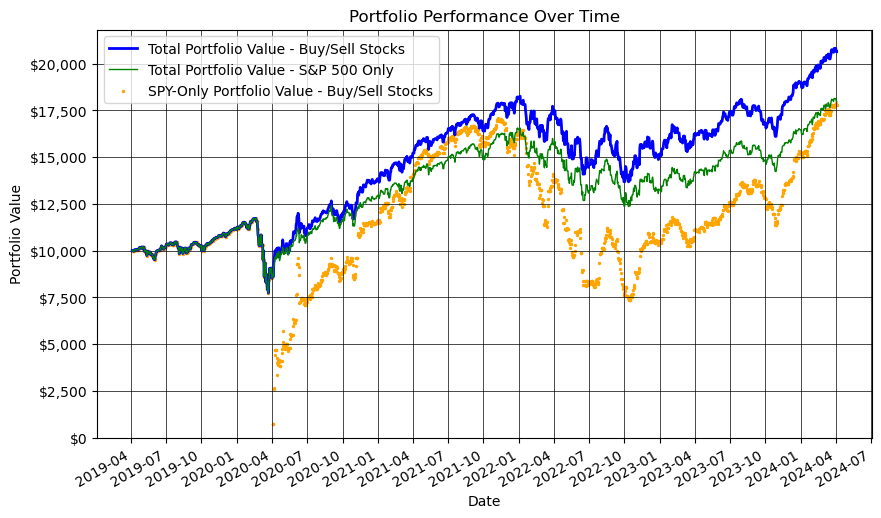

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plot_portfolio_value = portfolio_value.copy()
alt_plot_portfolio_value = alt_portfolio_value.copy()

# Convert 'Date' to datetime
plot_portfolio_value['Date'] = pd.to_datetime(plot_portfolio_value['Date'])
alt_plot_portfolio_value['Date'] = pd.to_datetime(alt_plot_portfolio_value['Date'])

# Set 'Date' as index
plot_portfolio_value.set_index('Date', inplace=True)
alt_plot_portfolio_value.set_index('Date', inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting 'Portfolio_Value' for both DataFrames as line graphs
plt.plot(
    plot_portfolio_value.index,
    plot_portfolio_value['Portfolio_Value'],
    label='Total Portfolio Value - Buy/Sell Stocks',
    linewidth=2,
    color='blue'
)
plt.plot(
    alt_plot_portfolio_value.index,
    alt_plot_portfolio_value['Portfolio_Value'],
    label='Total Portfolio Value - S&P 500 Only',
    linewidth=1,
    color='green'
)

# Plotting 'SPY_Portfolio_Value' for the 'portfolio_value' DataFrame as a scatter plot
plt.scatter(
    plot_portfolio_value.index,
    plot_portfolio_value['SPY_Portfolio_Value'],
    label='SPY-Only Portfolio Value - Buy/Sell Stocks',
    color='orange',
    s=2
)

# Format the x-axis to show dates every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))

# Rotate dates for better readability
plt.gcf().autofmt_xdate()

# Format the y-axis with a dollar sign and thousands separator
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Performance Over Time')
plt.legend()

# Enable minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')

plt.ylim(bottom=0)

# Show plot
plt.show()